# Scaled Average of Each Cluster

In [2]:
import pandas as pd
from prophet import Prophet
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import logging
%matplotlib inline

In [3]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [4]:
def calculate_mape(y_true, y_pred):
  return mean_absolute_percentage_error(y_true, y_pred) * 100

In [5]:
# Load the electricity usage data
NUM_CLUSTERS = 4

cluster_dfs = list()

for i in range(1, NUM_CLUSTERS + 1):
    df = pd.concat([
        pd.read_parquet(f'../dataset/cluster_{i}/training.parquet'),
        pd.read_parquet(f'../dataset/cluster_{i}/validation.parquet'),
        pd.read_parquet(f'../dataset/cluster_{i}/test.parquet'),
    ], axis=1).T.sort_index()
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    cluster_dfs.append(df)

In [6]:
explanatory_variables_df = pd.read_parquet('../dataset/combined_explanatory_variables/explanatory_variables.parquet')
explanatory_variables_df.index = pd.to_datetime(explanatory_variables_df.index)
explanatory_variables_df = explanatory_variables_df.sort_index().asfreq('D')

In [7]:
scaler = StandardScaler()

cutoff_date = pd.to_datetime('2014-01-01')

boxcox_dfs = list()
scaled_dfs = list()
mean_series = list()
mean_train_series = list()
mean_test_series = list()

for df in cluster_dfs:
    boxcox_df = df.apply(lambda column: boxcox(column)[0])
    scaled_df = pd.DataFrame(
        scaler.fit_transform(boxcox_df),
        index=boxcox_df.index,
        columns=boxcox_df.columns
    )
    mean = scaled_df.mean(axis=1)
    mean_train = mean[mean.index < cutoff_date]
    mean_test = mean[mean.index >= cutoff_date]
    boxcox_dfs.append(boxcox_df)
    scaled_dfs.append(scaled_df)
    mean_series.append(mean)
    mean_train_series.append(mean_train)
    mean_test_series.append(mean_test)

In [8]:
combined_dfs = list()
for i, df in enumerate(mean_train_series):
    combined_df = pd.concat([df, explanatory_variables_df], axis=1).rename(columns={0: 'y'})
    combined_df = combined_df[combined_df.index < cutoff_date]
    combined_df = combined_df.reset_index().rename(columns={'date': 'ds'})
    combined_dfs.append(combined_df)
combined_dfs[0]

,ds,y,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
0,2012-01-01,NaN,6.578559,0.0,0.000,0.0,0,10.0,1
1,2012-01-02,0.036451,6.659918,0.0,0.111,1.0,0,10.0,0
2,2012-01-03,0.116110,7.977833,0.0,0.000,0.0,0,10.0,0
3,2012-01-04,0.161707,6.335269,0.0,0.000,0.0,0,10.0,0
4,2012-01-05,0.123626,7.437771,0.0,0.000,0.0,0,10.0,0
...,...,...,...,...,...,...,...,...,...
726,2013-12-27,-0.271886,5.549002,0.0,0.048,1.0,0,9.0,0
727,2013-12-28,-0.437442,8.432045,0.0,0.101,1.0,0,9.0,1
728,2013-12-29,-0.608744,9.526014,0.0,0.006,1.0,0,9.0,1
729,2013-12-30,-0.446331,9.994676,0.0,0.000,0.0,0,10.0,0


In [9]:
explanatory_variables_df = explanatory_variables_df.reset_index().rename(columns={'date': 'ds'})
explanatory_variables_df

,ds,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
0,2012-01-01,6.578559,0.0,0.000,0.0,0,10.0,1
1,2012-01-02,6.659918,0.0,0.111,1.0,0,10.0,0
2,2012-01-03,7.977833,0.0,0.000,0.0,0,10.0,0
3,2012-01-04,6.335269,0.0,0.000,0.0,0,10.0,0
4,2012-01-05,7.437771,0.0,0.000,0.0,0,10.0,0
...,...,...,...,...,...,...,...,...
1092,2014-12-28,7.697900,0.0,0.000,0.0,0,9.0,1
1093,2014-12-29,10.921202,0.0,0.000,0.0,0,9.0,0
1094,2014-12-30,11.066679,0.0,0.000,0.0,0,9.0,0
1095,2014-12-31,10.832410,0.0,0.000,0.0,0,10.0,0


In [10]:
explanatory_variables_test = explanatory_variables_df[explanatory_variables_df.ds >= cutoff_date][explanatory_variables_df.ds < pd.to_datetime('2015-01-01')]
explanatory_variables_test

C:\Users\brian\AppData\Local\Temp\ipykernel_9772\825775865.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  explanatory_variables_test = explanatory_variables_df[explanatory_variables_df.ds >= cutoff_date][explanatory_variables_df.ds < pd.to_datetime('2015-01-01')]


,ds,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
731,2014-01-01,5.452926,0.0,0.089,1.0,0,10.0,0
732,2014-01-02,3.990161,0.0,0.083,1.0,0,10.0,0
733,2014-01-03,5.410022,0.0,0.348,1.0,0,10.0,0
734,2014-01-04,7.687619,0.0,0.584,1.0,0,10.0,1
735,2014-01-05,6.614942,0.0,0.000,0.0,0,10.0,1
...,...,...,...,...,...,...,...,...
1091,2014-12-27,9.032632,0.0,0.000,0.0,0,9.0,1
1092,2014-12-28,7.697900,0.0,0.000,0.0,0,9.0,1
1093,2014-12-29,10.921202,0.0,0.000,0.0,0,9.0,0
1094,2014-12-30,11.066679,0.0,0.000,0.0,0,9.0,0


## Cluster 1

In [11]:
model1 = Prophet()
model1.add_regressor('heating_degree_days')
model1.add_regressor('cooling_degree_days')
model1.add_regressor('precip')
model1.add_regressor('precipprob')
model1.add_regressor('is_holiday')
model1.add_regressor('sunlight_length_hours')
model1.add_regressor('is_weekend')
model1.fit(combined_dfs[0])
cluster1_test = model1.predict(explanatory_variables_test)

19:44:06 - cmdstanpy - INFO - Chain [1] start processing
19:44:06 - cmdstanpy - INFO - Chain [1] done processing


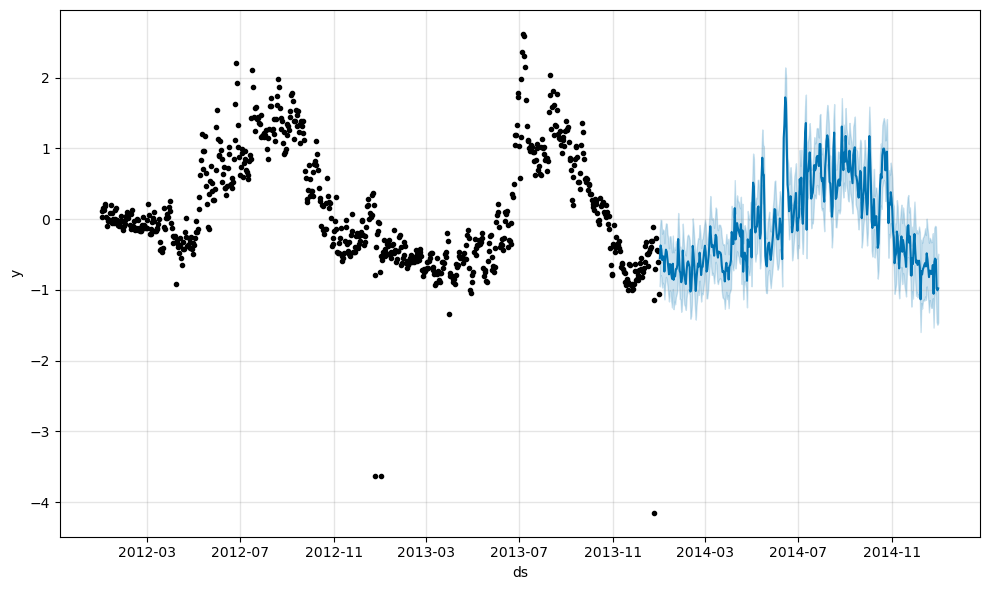

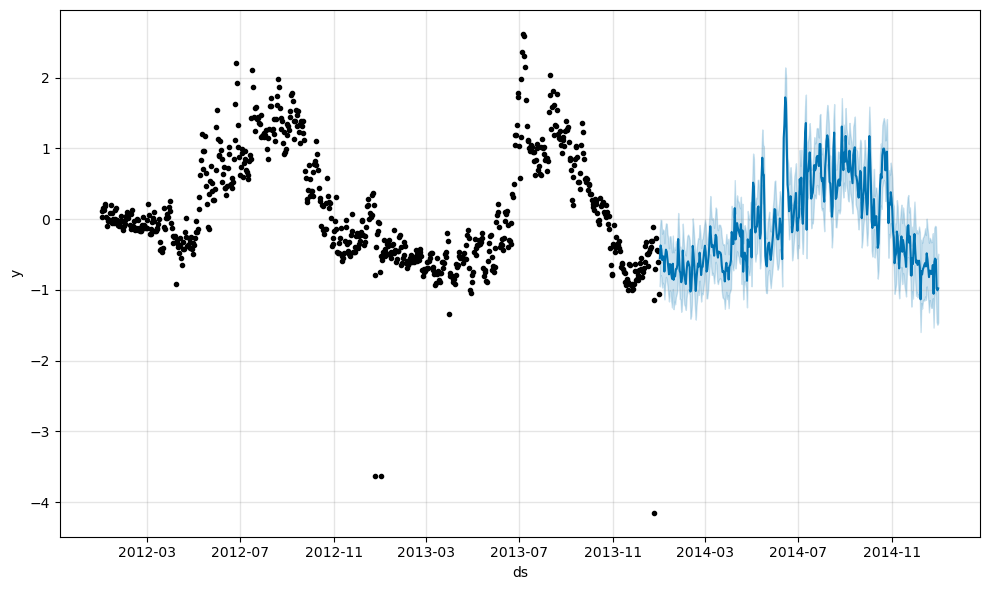

In [12]:
model1.plot(cluster1_test)

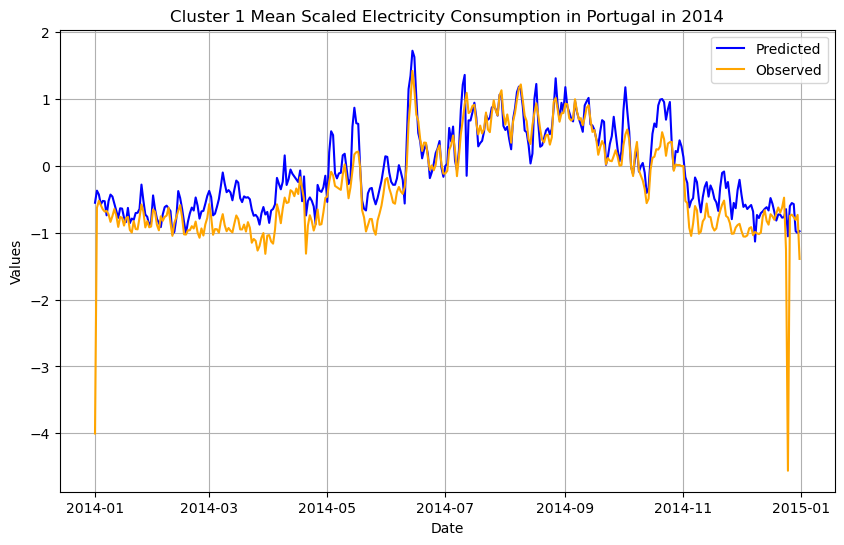

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(cluster1_test['ds'], cluster1_test['yhat'], label='Predicted', color='blue')
plt.plot(cluster1_test['ds'], mean_test_series[0], label='Observed', color='orange')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Cluster 1 Mean Scaled Electricity Consumption in Portugal in 2014')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
test_mape = calculate_mape(mean_test_series[0], cluster1_test['yhat'])
print(f'Test MAPE: {test_mape}')

Test MAPE: 170.56030732086674


## Cluster 2

In [15]:
model2 = Prophet()
model2.add_regressor('heating_degree_days')
model2.add_regressor('cooling_degree_days')
model2.add_regressor('precip')
model2.add_regressor('precipprob')
model2.add_regressor('is_holiday')
model2.add_regressor('sunlight_length_hours')
model2.add_regressor('is_weekend')
model2.fit(combined_dfs[1])
cluster2_test = model2.predict(explanatory_variables_test)

19:44:07 - cmdstanpy - INFO - Chain [1] start processing
19:44:07 - cmdstanpy - INFO - Chain [1] done processing


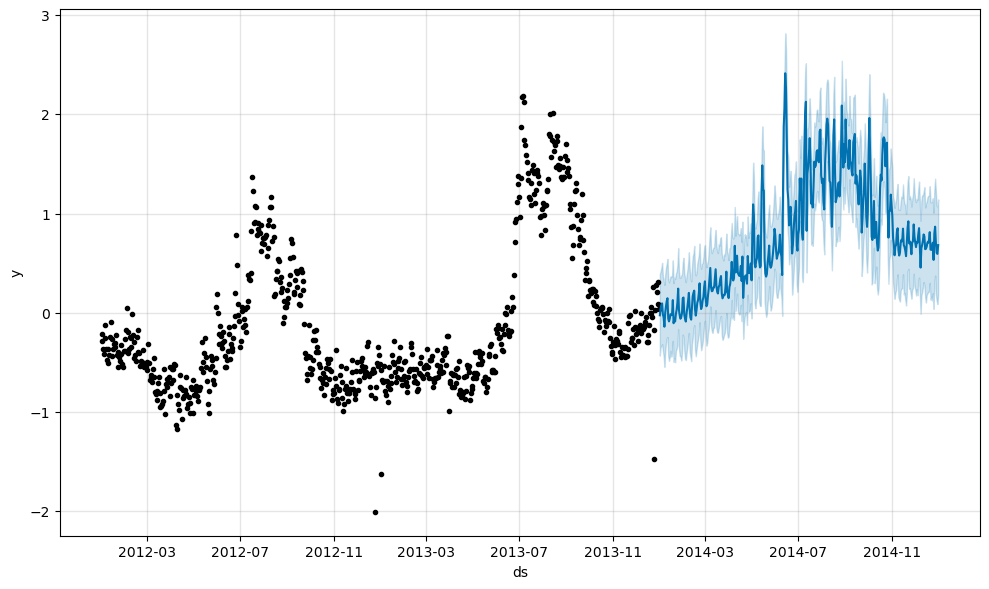

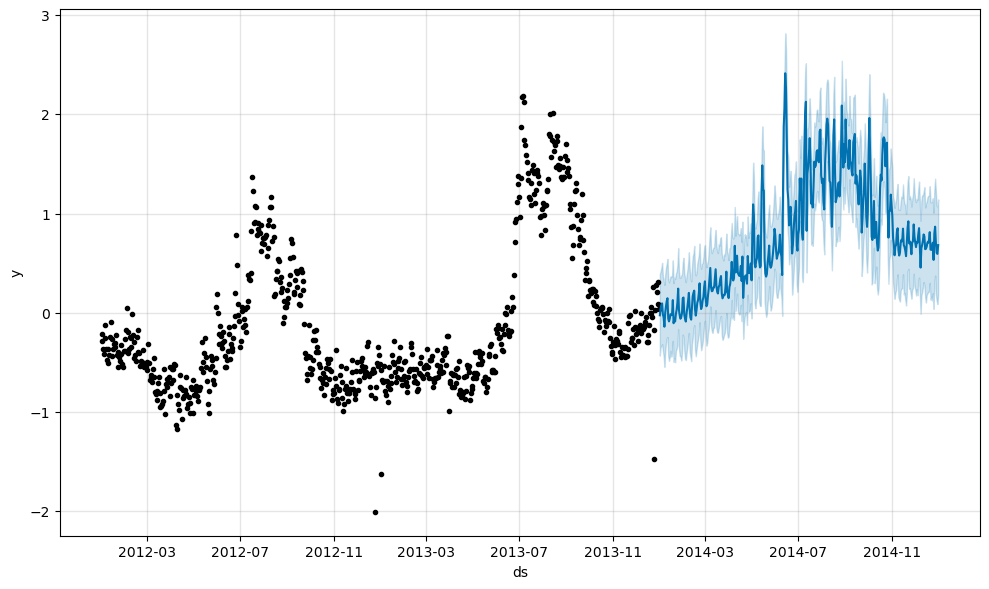

In [16]:
model2.plot(cluster2_test)

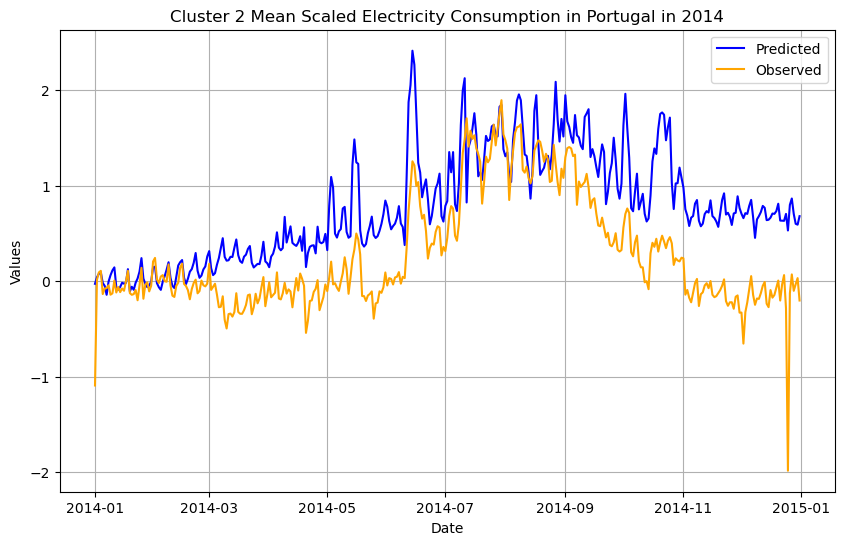

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(cluster2_test['ds'], cluster2_test['yhat'], label='Predicted', color='blue')
plt.plot(cluster2_test['ds'], mean_test_series[1], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Cluster 2 Mean Scaled Electricity Consumption in Portugal in 2014')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
test_mape = calculate_mape(mean_test_series[1], cluster2_test['yhat'])
print(f'Test MAPE: {test_mape}')

Test MAPE: 776.0191683580442


## Cluster 3

In [19]:
model3 = Prophet()
model3.add_regressor('heating_degree_days')
model3.add_regressor('cooling_degree_days')
model3.add_regressor('precip')
model3.add_regressor('precipprob')
model3.add_regressor('is_holiday')
model3.add_regressor('sunlight_length_hours')
model3.add_regressor('is_weekend')
model3.fit(combined_dfs[2])
cluster3_test = model3.predict(explanatory_variables_test)

19:44:08 - cmdstanpy - INFO - Chain [1] start processing
19:44:08 - cmdstanpy - INFO - Chain [1] done processing


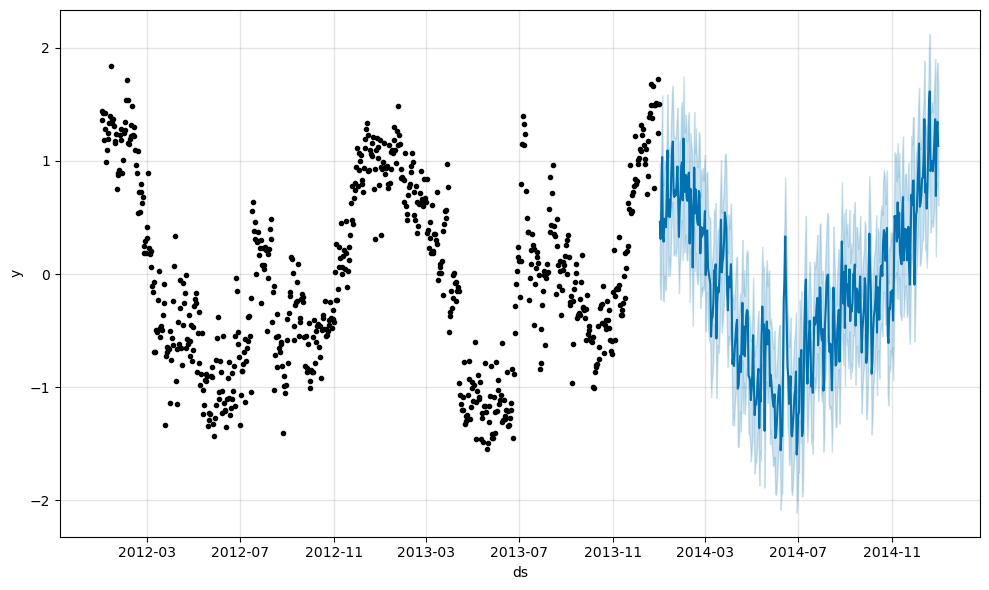

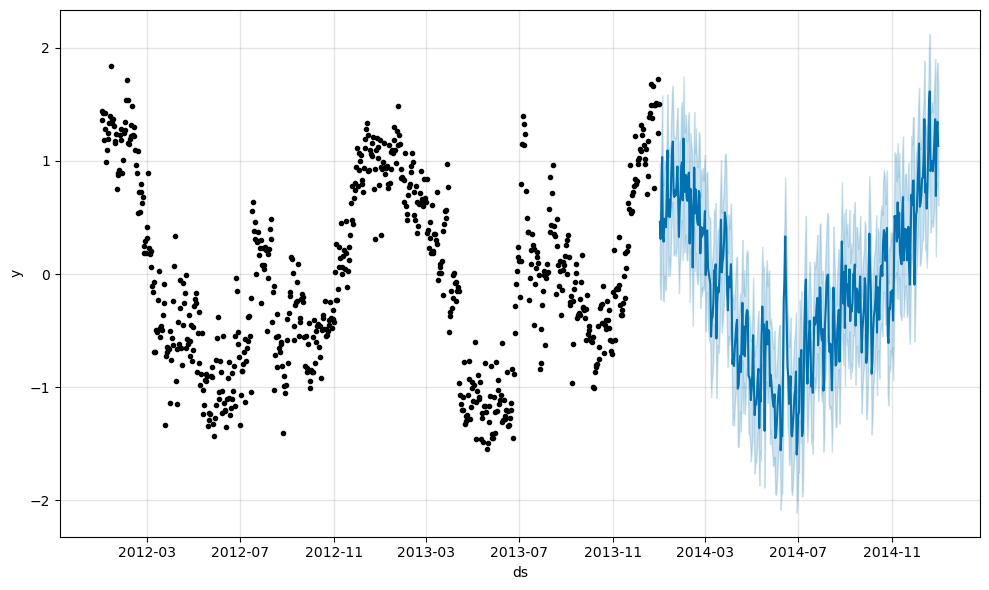

In [20]:
model3.plot(cluster3_test)

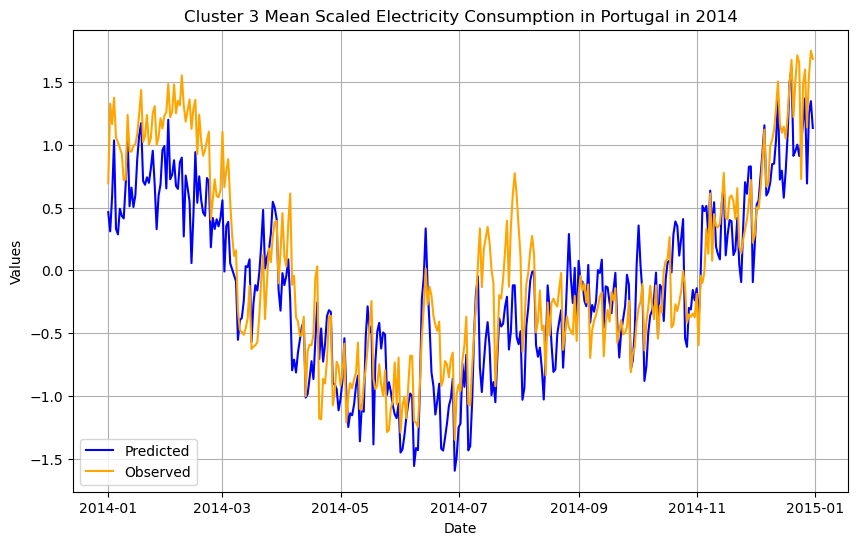

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(cluster3_test['ds'], cluster3_test['yhat'], label='Predicted', color='blue')
plt.plot(cluster3_test['ds'], mean_test_series[2], label='Observed', color='orange')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Cluster 3 Mean Scaled Electricity Consumption in Portugal in 2014')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
test_mape = calculate_mape(mean_test_series[2], cluster3_test['yhat'])
print(f'Test MAPE: {test_mape}')

Test MAPE: 252.37861708487958


## Cluster 4

In [23]:
model4 = Prophet()
model4.add_regressor('heating_degree_days')
model4.add_regressor('cooling_degree_days')
model4.add_regressor('precip')
model4.add_regressor('precipprob')
model4.add_regressor('is_holiday')
model4.add_regressor('sunlight_length_hours')
model4.add_regressor('is_weekend')
model4.fit(combined_dfs[3])
cluster4_test = model4.predict(explanatory_variables_test)

19:44:08 - cmdstanpy - INFO - Chain [1] start processing
19:44:09 - cmdstanpy - INFO - Chain [1] done processing


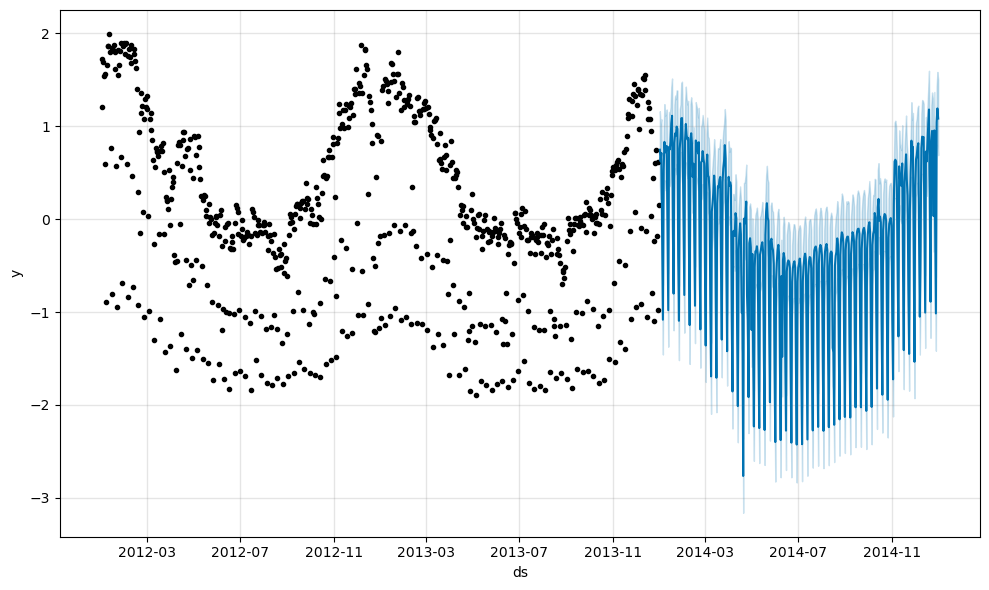

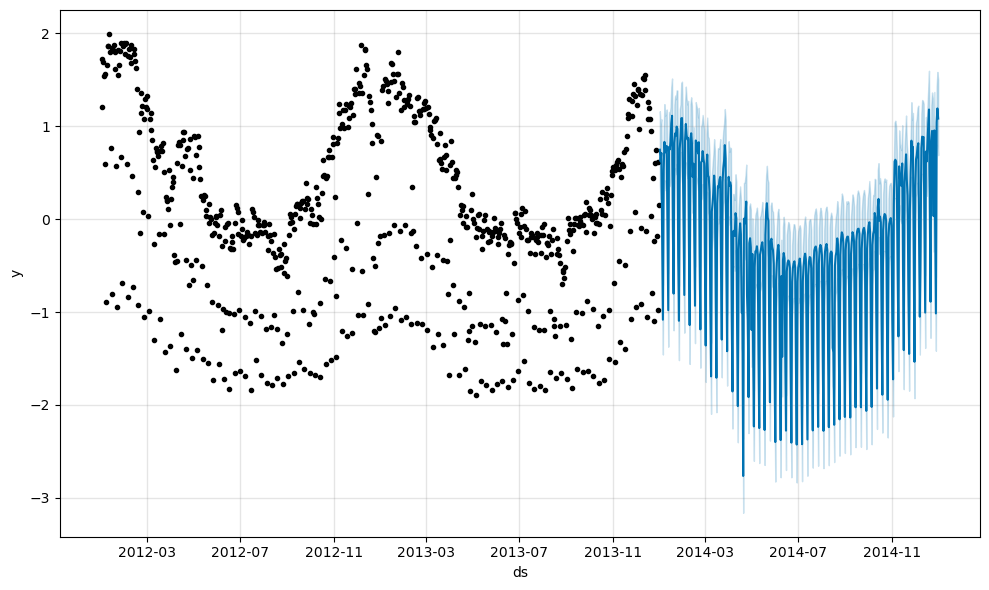

In [24]:
model4.plot(cluster4_test)

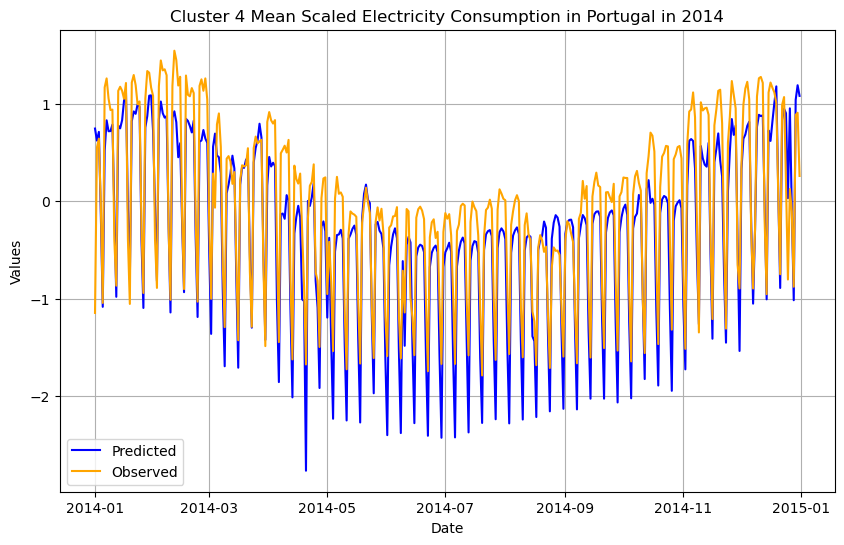

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(cluster4_test['ds'], cluster4_test['yhat'], label='Predicted', color='blue')
plt.plot(cluster4_test['ds'], mean_test_series[3], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Cluster 4 Mean Scaled Electricity Consumption in Portugal in 2014')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
test_mape = calculate_mape(mean_test_series[3], cluster4_test['yhat'])
print(f'Test MAPE: {test_mape}')

Test MAPE: 263.83565678483757
